# This Notebook produces a bunch of SBML Models which can be merged together in different ways.

## The Models are merged in the BioscrapeConnector and OneWayMap notebook.

This notebook uses [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler/pull/220) to produce SBML Models. This package is not a formal prerequisit for Vivarium-Bioscrape. Please install the package with the terminal command

    pip install biocrnpyler
   
or download and install the package directly from the github repository. 

In [1]:
%matplotlib inline
try:
    #SBML is created and saved with BioCRNpyler
    from biocrnpyler import * 
except ModuleNotFoundError:
    print("BioCRNpyler not installed. Please install the package using pip:\n\t pip install biocrnpyler\n")
    raise

#Used for arrays and plotting
import numpy as np
import pylab as plt
timepoints = np.arange(0, 100, .1)

## Model 1: Simple Transcription and Translation
$G \rightarrow G + T$

$T \rightarrow T + X$

Species(N = 3) = {
dna[G] (@ 10),  protein[X] (@ 0),  rna[T] (@ 0),  
}

Reactions (2) = [
0. dna[G] --> dna[G]+rna[T]
 Kf=k_forward * dna_G
  k_forward=0.2221875

1. rna[T] --> rna[T]+protein[X]
 Kf=k_forward * rna_T
  k_forward=0.075

]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-1.0.2-py3.7.egg\biocrnpyler\parameter.py:502: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].


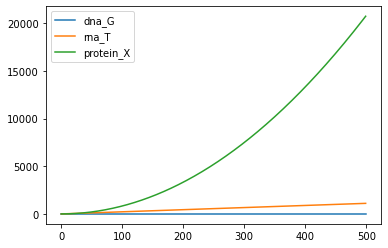

In [23]:
%matplotlib inline
#Create Mechanisms
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt")
M.add_mechanism(mech_tx)
M.add_mechanism(mech_tl)

#Create DNAassembly
G = DNAassembly("G", rbs = "medium", promoter = "medium", transcript = "T", protein = "X", initial_concentration = 10)
M.add_component(G)

#Compile the CRN
CRN = M.compile_crn()
print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model1.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

# Model 1b: 2 Gene Simple Transcription Translation
This is the same as Model 1, but with two different genes.

Species(N = 5) = {
dna[G1] (@ 1),  dna[G2] (@ 0.2),  protein[X] (@ 0),  rna[T2] (@ 0),  rna[T1] (@ 0),  
}

Reactions (4) = [
0. dna[G1] --> dna[G1]+rna[T1]
 Kf=k_forward * dna_G1
  k_forward=0.2221875

1. rna[T1] --> rna[T1]+protein[X]
 Kf=k_forward * rna_T1
  k_forward=0.075

2. dna[G2] --> dna[G2]+rna[T2]
 Kf=k_forward * dna_G2
  k_forward=0.4775625

3. rna[T2] --> rna[T2]+protein[X]
 Kf=k_forward * rna_T2
  k_forward=0.06

]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-1.0.2-py3.7.egg\biocrnpyler\parameter.py:502: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].


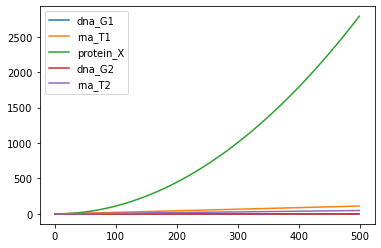

In [11]:
%matplotlib inline
#Create Mechanisms
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt")
M.add_mechanism(mech_tx)
M.add_mechanism(mech_tl)

#Create DNAassembly
G1 = DNAassembly("G1", rbs = "medium", promoter = "medium", transcript = "T1", protein = "X", initial_concentration = 1)
G2 = DNAassembly("G2", rbs = "weak", promoter = "strong", transcript = "T2", protein = "X", initial_concentration = .2)

M.add_component(G1)
M.add_component(G2)


#Compile the CRN
CRN = M.compile_crn()
print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model1b.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

## Model 2: Simple Transcription and Translation with Multiple Occupancy

$G \rightarrow G + T$

$T:Ribo^{closed}_{n-1} + Ribo \leftarrow \rightarrow T:Ribo^{open}_{n} \leftarrow \rightarrow T:Ribo^{closed}_{n} \rightarrow T + n Ribo + n X$

$T + Ribo \leftarrow \rightarrow T:Ribo^{open}_{1}$

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-1.0.2-py3.7.egg\biocrnpyler\parameter.py:502: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].


Species(N = 10) = {
protein[Ribo] (@ 150.0),  dna[G] (@ 10),  complex[protein[Ribo]:rna[T](closed)] (@ 0),  complex[protein[Ribo]:rna[T](open)] (@ 0),  complex[3x_protein[Ribo]:rna[T](closed)] (@ 0),  complex[3x_protein[Ribo]:rna[T](open)] (@ 0),  complex[2x_protein[Ribo]:rna[T](closed)] (@ 0),  complex[2x_protein[Ribo]:rna[T](open)] (@ 0),  protein[X] (@ 0),  rna[T] (@ 0),  
}

Reactions (12) = [
0. dna[G] --> dna[G]+rna[T]
 Kf=k_forward * dna_G
  k_forward=0.2221875

1. rna[T]+protein[Ribo] <--> complex[protein[Ribo]:rna[T](closed)]
 Kf=k_forward * rna_T * protein_Ribo
 Kr=k_reverse * complex_protein_Ribo_rna_T_closed_
  k_forward=100.0
  k_reverse=10.0

2. complex[protein[Ribo]:rna[T](closed)] --> complex[protein[Ribo]:rna[T](open)]
 Kf=k_forward * complex_protein_Ribo_rna_T_closed_
  k_forward=10.0

3. complex[2x_protein[Ribo]:rna[T](closed)] --> complex[2x_protein[Ribo]:rna[T](open)]
 Kf=k_forward * complex_protein_Ribo_2x_rna_T_closed_
  k_forward=10.0

4. complex[3x_protein[Ribo

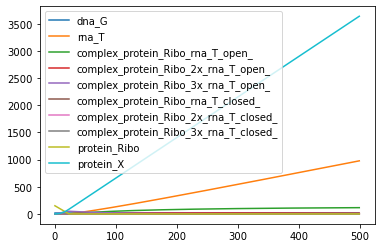

In [12]:
%matplotlib inline
#Create Mechanisms
mech_tx = SimpleTranscription()
ribo = Species("Ribo", material_type = "protein")
mech_tl = multi_tl(ribosome = ribo)

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt", parameters = {"max_occ":3})
M.add_mechanism(mech_tx)
M.add_mechanism(mech_tl)

#Create DNAassembly
G = DNAassembly("G", rbs = "medium", promoter = "medium", transcript = "T", protein = "X", initial_concentration = 10)
M.add_component(G)
CRN = M.compile_crn()

#Create
print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model2.xml", for_bioscrape = True)
                
#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

## Model 3: RNA Degredation with Binding

$T + RNAase \leftarrow \rightarrow T:RNAase \rightarrow RNAase$

Species(N = 3) = {
protein[RNAase] (@ 45.0),  rna[T] (@ 10),  complex[protein[RNAase]:rna[T]] (@ 0),  
}

Reactions (2) = [
0. rna[T]+protein[RNAase] <--> complex[protein[RNAase]:rna[T]]
 Kf=k_forward * rna_T * protein_RNAase
 Kr=k_reverse * complex_protein_RNAase_rna_T_
  k_forward=100.0
  k_reverse=10.0

1. complex[protein[RNAase]:rna[T]] --> protein[RNAase]
 Kf=k_forward * complex_protein_RNAase_rna_T_
  k_forward=0.001

]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-1.0.2-py3.7.egg\biocrnpyler\parameter.py:502: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].


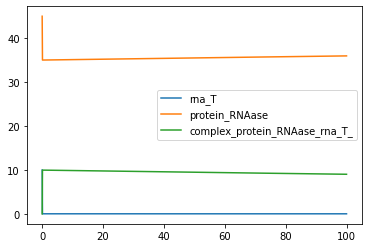

In [5]:
%matplotlib inline
#Create Mechanisms
rna = Species("T", material_type = "rna")
rnaase = Species("RNAase", material_type = "protein")
mech_deg = Degredation_mRNA_MM(rnaase)

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt", parameters = {str(rna):10})
M.add_mechanism(mech_deg)
M.add_species(rna)

CRN = M.compile_crn()

print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model3.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

# Model 4: Dilution of RNA and Protein
$R \to \emptyset$

$P \to \emptyset$

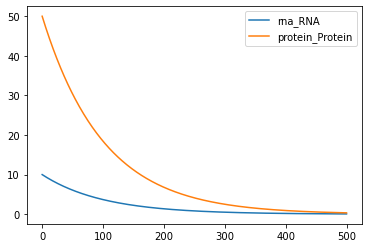

In [18]:
RNA = Species("RNA", material_type = "rna")
Protein = Species("Protein", material_type = "protein")
R1 = Reaction.from_massaction([RNA], [], k_forward = .01)
R2 = Reaction.from_massaction([Protein], [], k_forward = .01)

CRN4 = ChemicalReactionNetwork(species = [RNA, Protein], reactions = [R1, R2], initial_concentration_dict = {RNA:10, Protein:50})
CRN4.write_sbml_file("model4.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
R4 = CRN4.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN4.species:
    plt.plot(timepoints, R4[str(s)], label = str(s))
plt.legend()

# Model 5: Only Transcription

Modeled with binding of a polymerase $P$ to the gene $G$ which produces a trascript $T$

$G + P \leftrightarrow G:P \to G + P + T$

In [19]:
G = Species("G")
T = Species("T")
P = Species("P")
C = Complex([P, G])
R1 = Reaction.from_massaction([G, P], [C], k_forward = 10, k_reverse = 100)
R2 = Reaction.from_massaction([C], [T, G, P], k_forward = .15)
CRN = ChemicalReactionNetwork(species = [G, T, P, C], reactions = [R1, R2])

CRN.write_sbml_file("model5.xml", for_bioscrape = True, stochastic = True) #This model will be simulated stochastically
print(CRN.pretty_print())

Species(N = 4) = {
T (@ 0),  P (@ 0),  complex[G:P] (@ 0),  G (@ 0),  
}

Reactions (2) = [
0. G+P <--> complex[G:P]
 Kf=k_forward * G * P
 Kr=k_reverse * complex_G_P_
  k_forward=10
  k_reverse=100

1. complex[G:P] --> T+G+P
 Kf=k_forward * complex_G_P_
  k_forward=0.15

]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Model 6: Translation and Dilution
Translation is modeled with binding of a ribosome $R$ to the transcript $T$ which produces a protein $X$
$T + R \leftrightarrow T:R \to T + R + X$

Dilution of the transcript and protein
$T \to \emptyset \quad X \to \emptyset$

In [20]:
T = Species("T")
R = Species("R")
X = Species("X")
C = Complex([T, R])
R1 = Reaction.from_massaction([T, R], [C], k_forward = 100, k_reverse = 10)
R2 = Reaction.from_massaction([C], [T, R, X], k_forward = .15)
R3 = Reaction.from_massaction([T], [], k_forward = .05)
R4 = Reaction.from_massaction([X], [], k_forward = .05)
CRN = ChemicalReactionNetwork(species = [T, R, C, X], reactions = [R1, R2, R3, R4])

CRN.write_sbml_file("model6.xml", for_bioscrape = True) #This model will be simulated deterministically
print(CRN.pretty_print())

Species(N = 4) = {
X (@ 0),  T (@ 0),  complex[R:T] (@ 0),  R (@ 0),  
}

Reactions (4) = [
0. T+R <--> complex[R:T]
 Kf=k_forward * T * R
 Kr=k_reverse * complex_R_T_
  k_forward=100
  k_reverse=10

1. complex[R:T] --> T+R+X
 Kf=k_forward * complex_R_T_
  k_forward=0.15

2. T --> 
 Kf=k_forward * T
  k_forward=0.05

3. X --> 
 Kf=k_forward * X
  k_forward=0.05

]


# Faster Simulation of Models with Bioscrape

starting simulation
{'dna_G': 0, 'rna_T': 1, 'protein_X': 2}
starting simulation
{'dna_G': 0, 'rna_T': 1, 'complex_protein_Ribo_rna_T_open_': 2, 'complex_protein_Ribo_2x_rna_T_open_': 3, 'complex_protein_Ribo_3x_rna_T_open_': 4, 'complex_protein_Ribo_rna_T_closed_': 5, 'complex_protein_Ribo_2x_rna_T_closed_': 6, 'complex_protein_Ribo_3x_rna_T_closed_': 7, 'protein_Ribo': 8, 'protein_X': 9}
starting simulation
{'rna_T': 0, 'protein_RNAase': 1, 'complex_protein_RNAase_rna_T_': 2}


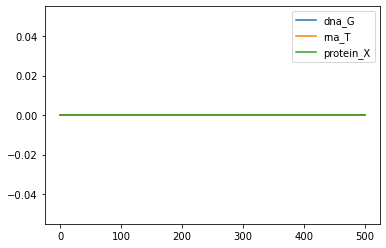

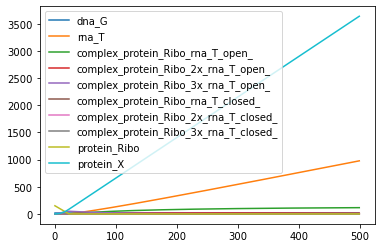

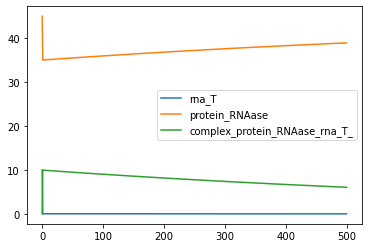

In [21]:
%matplotlib inline
from bioscrape.types import Model
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface

for filename in ["model1.xml", "model2.xml", "model3.xml"]:
    #The following code happens automatically above, but should only be done once in a simulation loop
    #Load SBML Model
    model = Model(sbml_filename = filename, sbml_warnings = False)
    #Create an Interface Model --> Cython
    interface = ModelCSimInterface(model)
    interface.py_prep_deterministic_simulation()
    #Create a Simulator
    simulator = DeterministicSimulator()
    
    #How to change the initial conditions
    initial_condition_dict = None
    if initial_condition_dict is not None:
        model.set_species(initial_condition_dict)
        
    #How to get parameters:
    #model.get_params2index() #Returns a dictionary param_name --> index
    #model.get_param_list() #gets a list of parameters
    
    #How to set parameters
    #model.set_params(dict) #param_name --> new value
    
    print("starting simulation")
    output = simulator.py_simulate(interface, timepoints)
    
    print(model.get_species2index())
    plt.figure()
    for s in model.get_species2index():
        plt.plot(timepoints, output.py_get_result()[:, model.get_species2index()[s]], label = str(s))
    
    plt.legend()

# Model 1_3

Species(N = 5) = {
protein[RNAase] (@ 45.0),  complex[protein[RNAase]:rna[T]] (@ 0),  protein[X] (@ 0),  rna[T] (@ 0),  dna[G] (@ 0),  
}

Reactions (4) = [
0. dna[G] --> dna[G]+rna[T]
 Kf=k_forward * dna_G
  k_forward=0.2221875

1. rna[T] --> rna[T]+protein[X]
 Kf=k_forward * rna_T
  k_forward=0.075

2. rna[T]+protein[RNAase] <--> complex[protein[RNAase]:rna[T]]
 Kf=k_forward * rna_T * protein_RNAase
 Kr=k_reverse * complex_protein_RNAase_rna_T_
  k_forward=100.0
  k_reverse=10.0

3. complex[protein[RNAase]:rna[T]] --> protein[RNAase]
 Kf=k_forward * complex_protein_RNAase_rna_T_
  k_forward=0.001

]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\biocrnpyler-1.0.2-py3.7.egg\biocrnpyler\parameter.py:502: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].


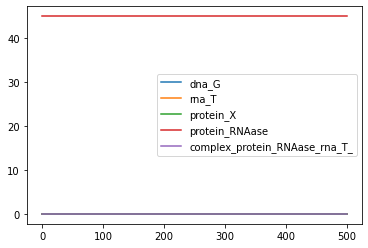

In [22]:
%matplotlib inline
#Create Species
rna = Species("T", material_type = "rna")
rnaase = Species("RNAase", material_type = "protein")

#Create Mechanisms
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()
mech_deg = Degredation_mRNA_MM(rnaase)

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt")
M.add_mechanism(mech_tx)
M.add_mechanism(mech_tl)
M.add_mechanism(mech_deg)

#Create DNAassembly
G = DNAassembly("G", rbs = "medium", promoter = "medium", transcript = rna, protein = "X", initial_conc = 1.0)
M.add_component(G)

#Compile the CRN
CRN = M.compile_crn()
print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model1_3.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
timepoints = np.arange(0, 500, 1)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()